<a href="https://colab.research.google.com/github/jairo-nlp/valuation/blob/master/Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [758]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from itertools import combinations
from pandas_datareader.data import DataReader
from datetime import date


start = date(2018, 3, 1)
end = date(2020, 7, 30)

ativos = {
    'bancos': [
               'ITSA4.SA', 
               'BBDC4.SA', 
               'BBAS3.SA', 
               'SANB4.SA'
               ],
    'industrial': [
                   'WEGE3.SA', 
                   'TUPY3.SA', 
                   'MYPK3.SA', 
                   'SHUL4.SA'
                   ],
    'varejo': [
               'VVAR3.SA', 
               'BTOW3.SA', 
               'MGLU3.SA'
               ],
    'imobiliário': [
                    'TRIS3.SA', 
                    'ALSO3.SA', 
                    'MRVE3.SA', 
                    'EZTC3.SA', 
                    'TCSA3.SA',
                    'CYRE3.SA'],
    'saúde': [
              'AALR3.SA', 
              'FLRY3.SA', 
              'QUAL3.SA'
              ]
           }

data_source = 'yahoo'

In [769]:
# Classe análise

class Analise():

    def __init__(self, ativos, data_ini, data_fim):
        """Análise de setores e ativos.

        :param ativos: Dicionário da forma
        {'setor1': ['ticker1', 'ticker2', ...],
        'setor2': ['ticker3', 'ticker4', ...],
        ...
        'setorN': ['tickerM', ...]
        }
        :param data_ini: data de inicio da analise
        :param data_fim: data de final da analise
        """

        self.setores_tickers = ativos

        self.setores = list(self.setores_tickers.keys())
        self.cores = {setor: f'C{idx + 1}' for idx, setor in enumerate(self.setores)}

        self.data_ini = pd.to_datetime(data_ini)
        self.data_fim = pd.to_datetime(data_fim)
    
    def __str__(self):
        msg_ret = ('Ativos:\n' + str(self.setores_tickers)
                   + '\nData Inicial:\t' + self.data_ini.strftime('%m/%Y')
                   + '\nData Final:\t' + self.data_fim.strftime('%m/%Y')
        )

        return msg_ret

print(Analise(ativos, start, end))
  



Ativos:
{'bancos': ['ITSA4.SA', 'BBDC4.SA', 'BBAS3.SA', 'SANB4.SA'], 'industrial': ['WEGE3.SA', 'TUPY3.SA', 'MYPK3.SA', 'SHUL4.SA'], 'varejo': ['VVAR3.SA', 'BTOW3.SA', 'MGLU3.SA'], 'imobiliário': ['TRIS3.SA', 'ALSO3.SA', 'MRVE3.SA', 'EZTC3.SA', 'TCSA3.SA', 'CYRE3.SA'], 'saúde': ['AALR3.SA', 'FLRY3.SA', 'QUAL3.SA']}
Data Inicial:	03/2018
Data Final:	07/2020


In [741]:
def obtem_dados_setor(setor):
  """Retorna df com dados das ações do setor informado
  """

  stock_data = DataReader(tickers[setor], data_source, start, end)
  return stock_data[['Adj Close']]

In [742]:
def normalizado(df):
  """Normaliza dados gerando o efeito de começarem todos em 1.

  Para integrar ao dataframe original, use o append.

  Ex: df.append(normalizado(df))

  :param df: dataframe de entrada com n ativos em multiindex
  :return df_norm: dataframe de saída, com a coluna normalizada mantendo o índice dos ativos, porém utilizando 'Norm Close' para o nível mais acima.
  """
  tickers = df.columns.levels[1]
  names = df.columns.names
  idx = df.index
  cols = pd.MultiIndex.from_product([['Norm Close'], tickers], names=names)

  return pd.DataFrame((df['Adj Close'] / (df['Adj Close'].iloc[0])).values, columns=cols, index=idx)

In [743]:
def obtem_tickers_legenda(legend_labels):
  filtro_rotulos = r'\,\s(.*)\.'
  rotulos_amigaveis = [re.findall(filtro_rotulos, el)[0] 
                       for el in legend_labels]
  return rotulos_amigaveis

In [744]:
def plot_linhas(df, setor=''):
  """Gera um gráfico das cotações das ações de um setor.
  :param df: dataframe com os dados de cotação normalizada
  :param setor: nome do setor
  """
  fig, ax = plt.subplots(figsize=(12, 6))
  df.plot(ax=ax)
  plt.xlabel('Tempo')
  plt.ylabel('Cotação')

  # Para incluir no título do gráfico
  data_ini = df.index[0].strftime('%m/%Y')
  data_fim = df.index[-1].strftime('%m/%Y')

  legend_labels = ax.get_legend_handles_labels()[1]
  ax.legend(obtem_tickers_legenda(legend_labels))

  plt.title(f'Cotação Relativa - {setor.upper()} - ({data_ini} - {data_fim})')
  plt.show()

In [745]:
def plot_linhas_compara_setores(dados, setores, cores, highlights=None):
  """Gera um gráfico das cotações das ações de um setor.
  :param dados: dataframe com os dados de cotação normalizada
  :param setores: lista de setores
  :param cores: dicionário de cores por setor
  :param highlights: lista de setores a destacar
  """
  fig, ax = plt.subplots(figsize=(12, 6))

  for setor in setores:
    df_setor = dados[setor]['Norm Close']
    
    # destaca setor(es) na lista de highlights
    if setor in highlights:
      alpha = 1
    else:
      alpha = 0.2

    df_setor.plot(ax=ax, color=cores[setor], alpha=alpha)

  plt.xlabel('Tempo')
  plt.ylabel('Cotação')

  # Para incluir no título do gráfico
  data_ini = df_setor.index[0].strftime('%m/%Y')
  data_fim = df_setor.index[-1].strftime('%m/%Y')

  legend_labels = ax.get_legend_handles_labels()[1]
  ax.legend(legend_labels)

  plt.title(f'Cotação Relativa - {str(highlights).upper()} - ({data_ini} - {data_fim})')
  plt.show()

In [746]:
def corrige_agrupamento(df, ticker, multiplicador, data_ant):
  """Corrige um agrupamento para trás da data

  :param data_ant: data do último dia de cotação antes do grupamento
  """

  df.loc[:data_ant, [('Adj Close', ticker)]] = multiplicador * df.loc[:data_ant, [('Adj Close', ticker)]]

In [747]:
dados = {}

In [748]:
for setor in setores:
  dados[setor] = obtem_dados_setor(setor=setor)

corrige_agrupamento(dados['imobiliário'], 'TCSA3.SA', 10, data_ant='2020-5-25')

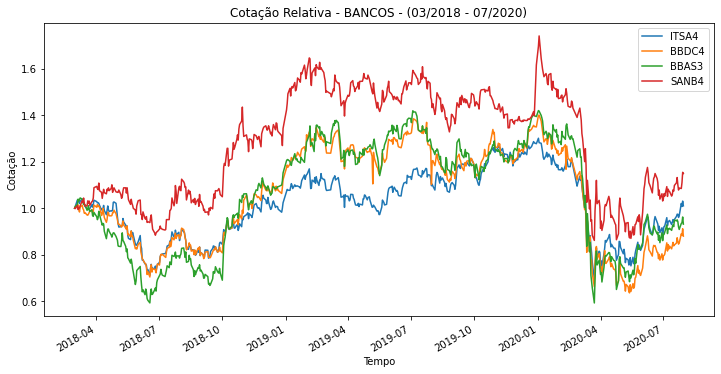

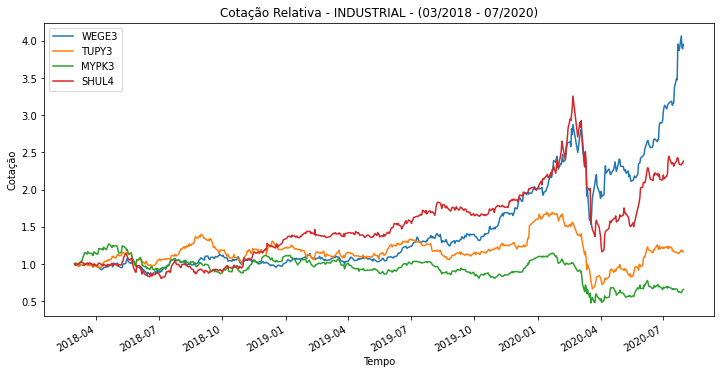

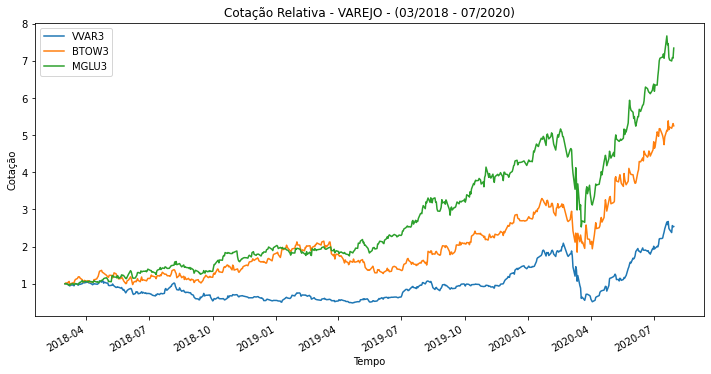

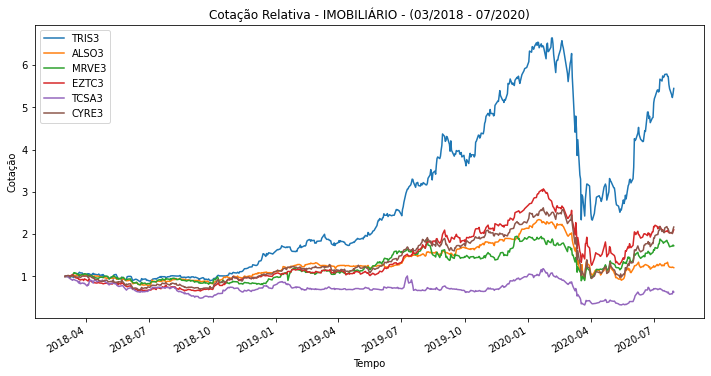

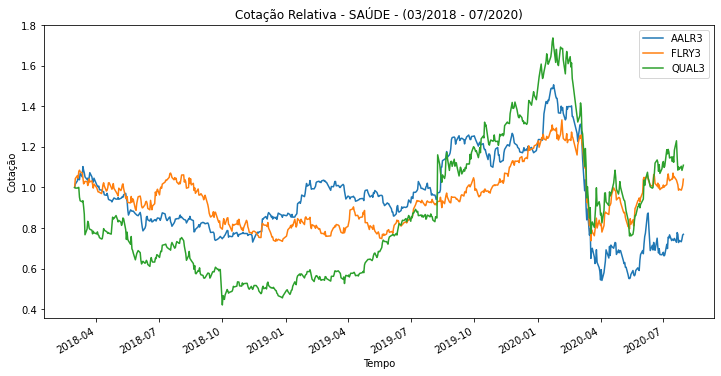

In [749]:
# Gera gráficos 
for setor in setores:
  dados_normalizados = normalizado(dados[setor])
  dados[setor] = pd.concat([dados[setor], dados_normalizados], axis=1)
  plot_linhas(dados_normalizados, setor=setor)

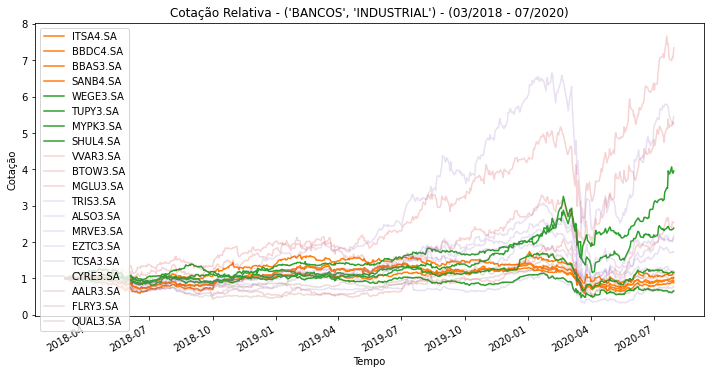

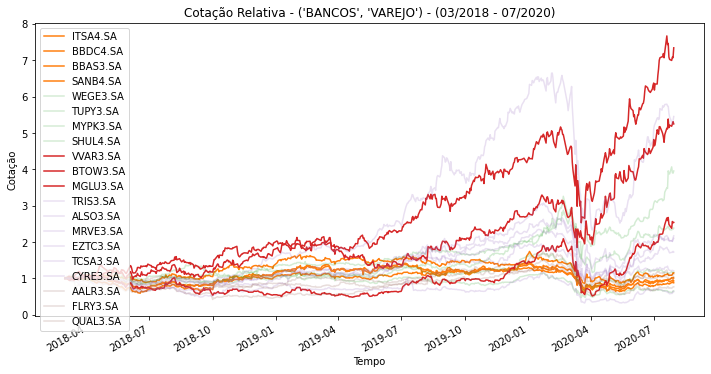

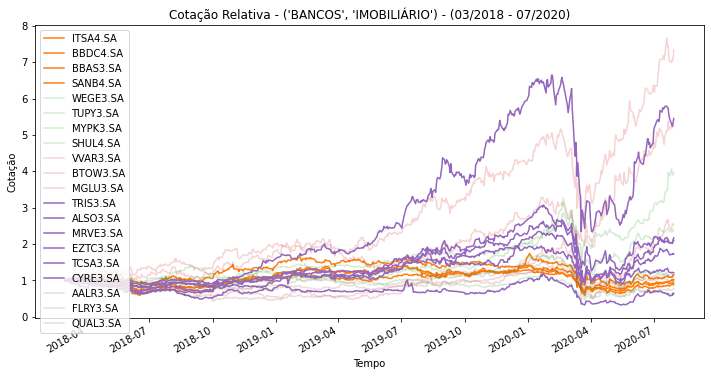

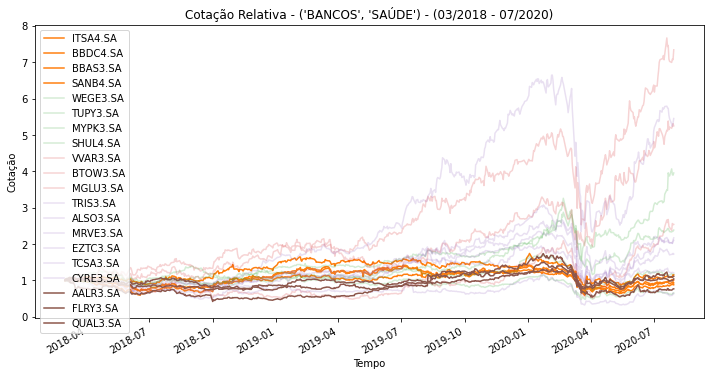

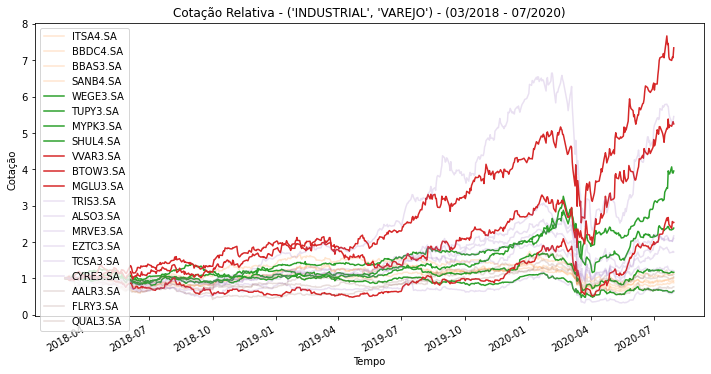

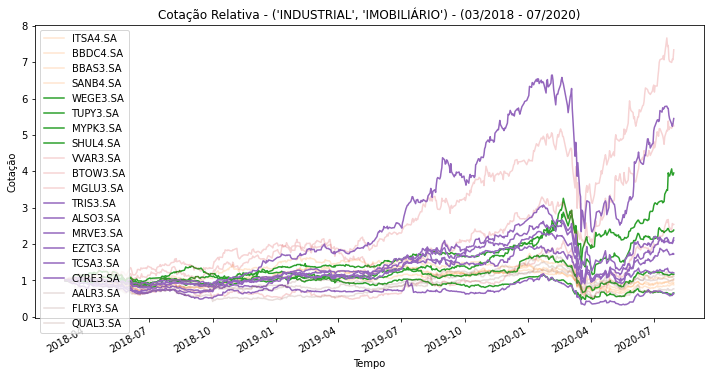

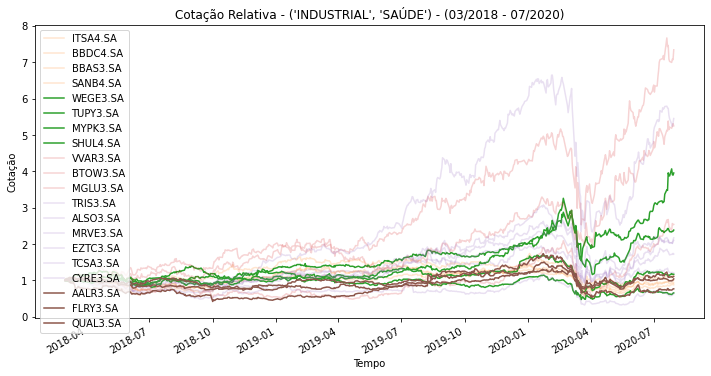

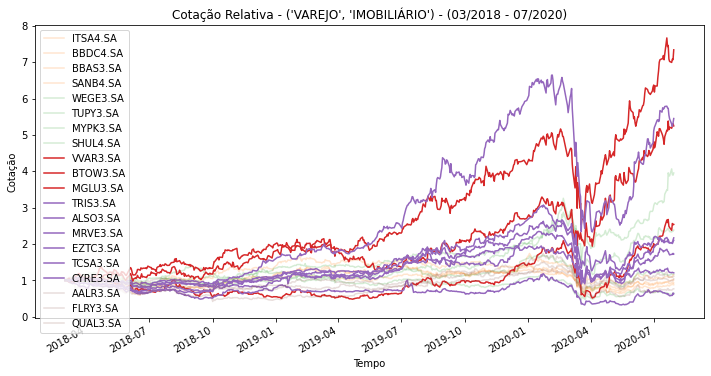

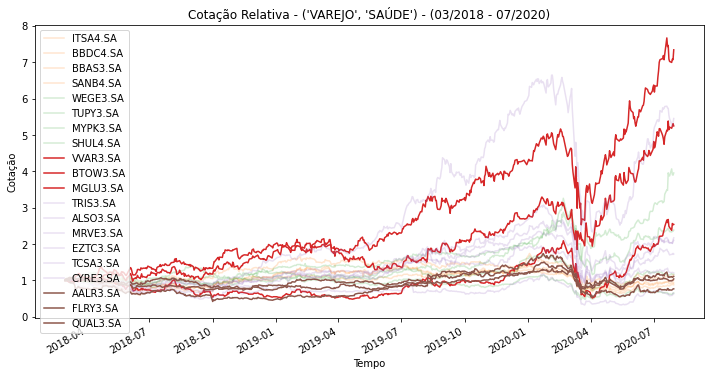

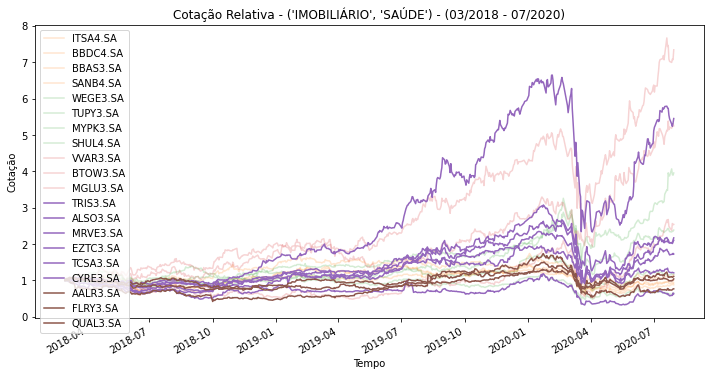

In [750]:
for par_de_setores in combinations(setores, 2):
  plot_linhas_compara_setores(dados, setores, cores, highlights=par_de_setores)